In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten , Input, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.utils.class_weight import compute_class_weight


import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

In [ ]:
# Data path
data_dir = "../Data"
train_dir = "../Data/train"
test_dir = "../Data/test"

# Image size and batch variable
img_height , img_weidth = 48 , 48
batch = 32

# Image Normalization to [0,1]
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
    )

# Note for the labes, the flow_from_directory assigns it according to the folder name
# Load training data
train_data = datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_weidth),
    batch_size = batch,
    class_mode = 'categorical',
    subset = 'training'
)



validation_data = datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_weidth),
    batch_size = batch,
    class_mode = 'categorical',
    subset='validation'
)

# Load test data
test_data = datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_weidth),
    batch_size = batch,
    class_mode = 'categorical',
    shuffle = False,
)

# Handeling Data imbalance 
# Get the class labels from the training data
class_labels = train_data.class_indices  

# Get the class indices 
class_indices = list(class_labels.values())

# Compute class weights based on class distribution in the training data
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(class_indices), 
                                     y=train_data.classes) 

# Convert class weights into a dictionary format for TensorFlow
class_weight_dict = {i: weight for i, weight in zip(class_indices, class_weights)}

print(class_weight_dict)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
{0: np.float64(1.0266404434114071), 1: np.float64(9.401555464592715), 2: np.float64(1.0009587727708533), 3: np.float64(0.5684585684585685), 4: np.float64(0.826068191627104), 5: np.float64(0.8491570541259982), 6: np.float64(1.2933160650937552)}


In [52]:
# Verify the data and its lable
# Check the output summary
print("Class names:", train_data.class_indices)
print("Number of batches per epoch:", train_data.samples // batch) 
print("Image shape:", train_data.image_shape)  
print("Number of classes:", len(train_data.class_indices))  

Class names: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Number of batches per epoch: 717
Image shape: (48, 48, 3)
Number of classes: 7


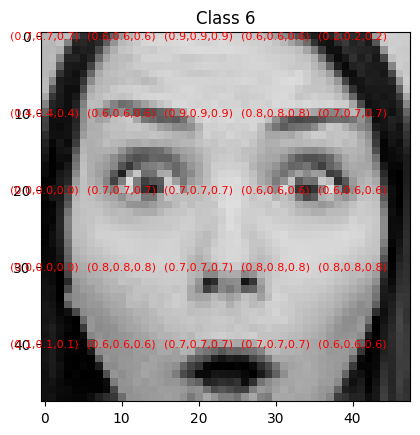

In [53]:
# Visualizing the image in its pixel value with 4 intervals

images , labels = next(train_data)
image = images[0]
label = labels[0]
c_value = np.argmax(label)

plt.imshow(image)
plt.title(f"Class {c_value}")

for i in range(0, img_height, 10):
    for j in range(0, img_weidth, 10):
        r, g, b = image[i, j]
        plt.text(j,i, f"({r:.1f},{g:.1f},{b:.1f})", color='red', fontsize=8, ha='center', va='center' )
plt.show()

Looking at the result of the model we can see that the model is overfitting as the traning accuracy after 10 epoch is 99.46% how ever the validation accuracy is at 45.01 %.

In [54]:
# intregrating convolution layers using pooling and drop out for over fitting
model = Sequential()

model.add(Input(shape=(img_height, img_weidth, 3)))
model.add(Conv2D(32, kernel_size= 3, activation='relu', padding='same' ))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size= 3, activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size= 3, activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))


# intregrating Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(7, activation='softmax'))
 
# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,103 (2.61 MB)

 Trainable params: 684,103 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Stop the traing when accuracy and validation widens more then 0.1

class Overfitting(Callback):
    def __init__(self, threshold=0.1, patience=2):  
        super(Overfitting, self).__init__()
        self.threshold = threshold
        self.patience = patience
        self.counter = 0  

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if acc and val_acc:
            gap = acc - val_acc  
            print(f"\nEpoch {epoch+1}: Accuracy gap = {gap:.4f}")

            if gap > self.threshold:  
                self.counter += 1
                if self.counter >= self.patience:
                    print(f"\nStopping training: Accuracy gap exceeded {self.threshold} for {self.patience} epochs.")
                    self.model.stop_training = True
            else:
                self.counter = 0  

stop_overfitting = Overfitting(threshold=0.1, patience=2)

# Solwer the learning rate if the val_loss doen't improve in 3 epoch
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

training = model.fit(train_data, epochs=20, validation_data = validation_data, callbacks=[reduce_lr, stop_overfitting], class_weight=class_weight_dict)


Epoch 1/20


/home/minso/miniconda3/envs/aai/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1735 - loss: 1.9472
Epoch 1: Accuracy gap = -0.0595
718/718 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step - accuracy: 0.1736 - loss: 1.9472 - val_accuracy: 0.2686 - val_loss: 1.7688 - learning_rate: 5.0000e-04
Epoch 2/20
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2981 - loss: 1.7494
Epoch 2: Accuracy gap = -0.0805
718/718 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.2982 - loss: 1.7493 - val_accuracy: 0.4011 - val_loss: 1.5994 - learning_rate: 5.0000e-04
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3570 - loss: 1.6442
Epoch 3: Accuracy gap = -0.0597
718/718 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.3570 - loss: 1.6441 - val_accuracy: 0.4295 - val_loss: 1.4961 - learning_rate: 5.0000e-04
Epoch 4/20
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4090 - loss: 1.4740
Epoch 4: Accuracy gap = -0.0338
718/718 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.4090 - loss: 1.4740 - val_accuracy: 0

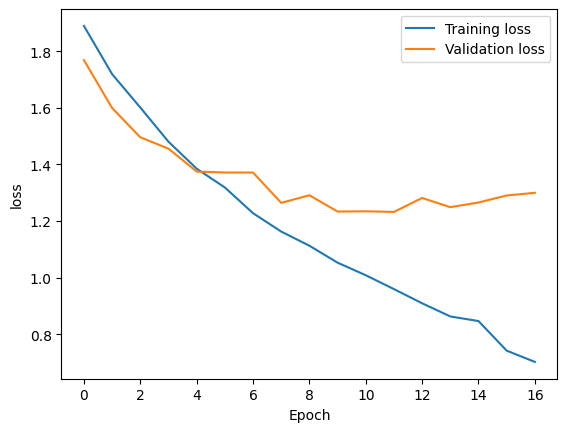

In [56]:
plt.plot(training.history['loss'], label= "Training loss")
plt.plot(training.history['val_loss'], label= "Validation loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

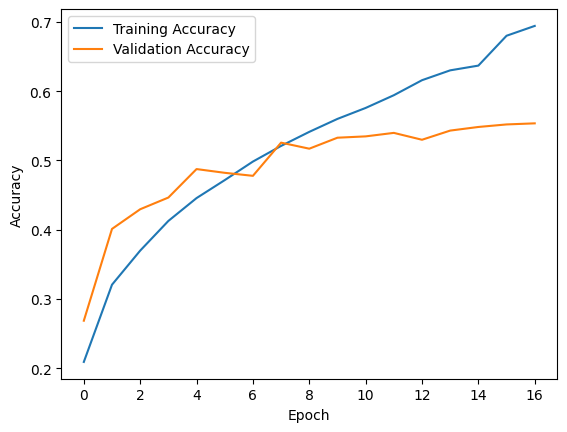

In [57]:
plt.plot(training.history['accuracy'], label="Training Accuracy")
plt.plot(training.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [16]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5627 - loss: 1.2690
Test Loss: 1.2593
Test Accuracy: 0.5642


In [20]:
# Get the test data batches
test_images, test_labels = next(test_data)

# Make predictions on the test images
predictions = model.predict(test_images)

# Convert predictions from probabilities to class labels
predicted= np.argmax(predictions, axis=1)

# Compare predictions to the actual labels
actual = np.argmax(test_labels, axis=1)


# Calculate accuracy on the test set
accuracy = accuracy_score(actual, predicted)
print(f"Accuracy on test set: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Accuracy on test set: 0.5938
